In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/drive')

# directorio local en Google Drive
path = '/content/drive/MyDrive/'  #@param {type:"string"}


Mounted at /content/drive


In [ ]:
data_file = 'dzone_architecture_design_news_date_cleaned.csv'  #@param {type:"string"}
delimitador_columnas = ',' #@param {type:"string"}


In [ ]:
npr = pd.read_csv(path + data_file,
                  quotechar='"',
                  on_bad_lines='skip',
                  parse_dates=['Date'],
                  na_values=[],  # Trata las celdas vacías como cadenas vacías en lugar de NaN
                  keep_default_na=False)

<ipython-input-6-1a9c45180b22>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  npr = pd.read_csv(path + data_file,


In [ ]:
npr.head()

,Title,URL,Detail,Date,Author,Views
0,Serverless Computing and GraphQL: Modern App D...,https://dzone.com/articles/serverless-computin...,"In this step-by-step guide, learn how to defin...",2024-10-14,balaji thadagam kandavel,"2,860 Views"
1,CI/CD Pipelines in the Cloud: How Cloud Hostin...,https://dzone.com/articles/cicd-pipelines-in-t...,Cloud-hosted CI/CD pipelines enhance software ...,2024-10-14,Anton Lucanus,"2,217 Views"
2,What We Learned About Secrets Security at AppS...,https://dzone.com/articles/secrets-security-at...,"Learn about DEF CON 32: AppSec Village, explor...",2024-10-14,Dwayne McDaniel,"2,051 Views"
3,Mutable vs. Immutable: Infrastructure Models i...,https://dzone.com/articles/infrastructure-mode...,Explore mutable infrastructure and immutable s...,2024-10-14,Josephine Eskaline Joyce,"3,647 Views"
4,An Overview of TCPCopy for Beginners,https://dzone.com/articles/an-overview-of-tcpc...,"In this article, learn more about TCPCopy, an ...",2024-10-11,Bin Wang,"3,245 Views"


In [ ]:
print(f"Corpus size: {len(npr)} documents")

Corpus size: 12923 documents


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer(max_df=0.9,min_df=2,stop_words='english')

In [ ]:
dtm = cv.fit_transform(npr['Detail'])

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

Results loaded from existing file.


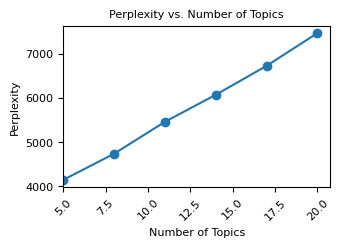

Number of Topics: 5, Perplexity: 4149.644530405782
Number of Topics: 8, Perplexity: 4740.044044593153
Number of Topics: 11, Perplexity: 5459.439844783337
Number of Topics: 14, Perplexity: 6069.066148475124
Number of Topics: 17, Perplexity: 6721.327575163785
Number of Topics: 20, Perplexity: 7459.900853094874


In [ ]:
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Results file
results_file = f'perplexities_{data_file}'

# Full path of results file
results_path = f'{path}{results_file}'

# Check if results file already exists
import os
if results_file in os.listdir(path):
    # Load existing results
    results = pd.read_csv(results_path)
    topic_range = results['Number of Topics'].values
    perplexities = results['Perplexity'].values
    print("Results loaded from existing file.")
else:
    # Split data into training and testing sets
    X_train, X_test = train_test_split(dtm, test_size=0.3, random_state=42)

    # Range of topic numbers to test
    topic_range = range(5, 21, 3)

    # Lists to store results
    perplexities = []

    for n_topics in tqdm(topic_range, desc="Training LDA models", unit="topics", bar_format="{l_bar}{bar}| {n}/{total} [{percentage:.0f}%] ({elapsed} elapsed, {remaining} remaining)"):
        # Train LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
        lda.fit(X_train)

        # Calculate perplexity
        perplexity = lda.perplexity(X_test)
        perplexities.append(perplexity)

    # Save results to CSV file
    results = pd.DataFrame({'Number of Topics': topic_range, 'Perplexity': perplexities})
    results.to_csv(results_path, index=False)
    print("Results saved to file.")

# Create figure with custom size
fig, ax = plt.subplots(figsize=(3.5, 2.5))

# Plot perplexity vs. number of topics
ax.plot(topic_range, perplexities, marker='o')
ax.set_xlabel('Number of Topics', fontsize=8)
ax.set_ylabel('Perplexity', fontsize=8)
ax.set_title('Perplexity vs. Number of Topics', fontsize=8)
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
ax.set_xlim(left=5)  # Start x-axis at 5

plt.tight_layout()
plt.show()

# Print results
for n_topics, perplexity in zip(topic_range, perplexities):
    print(f'Number of Topics: {n_topics}, Perplexity: {perplexity}')

In [ ]:
number_of_topics = topic_range[np.argmin(perplexities)]
print(f'Número de Tópicos con menor Perplexity: {number_of_topics}')

Número de Tópicos con menor Perplexity: 5


In [ ]:
LDA = LatentDirichletAllocation(n_components=number_of_topics,random_state=42)

In [ ]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
import numpy as np

def display_topic_analysis(lda_model, feature_names, top_n=10):
    for idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[:-top_n-1:-1]
        top_words = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        percentages = (weights / weights.sum()) * 100

        print(f"Topic {idx}: {', '.join(top_words[:3])}")
        print(", ".join(f"{word} ({pct:.1f}%) " for word, pct in zip(top_words, percentages)))
        print()

# Example usage
display_topic_analysis(LDA, cv.get_feature_names_out())

Topic 0: api, data, article
api (15.9%) , data (14.2%) , article (14.0%) , learn (12.4%) , using (10.6%) , service (8.2%) , use (8.1%) , spring (5.7%) , post (5.5%) , rest (5.3%) 

Topic 1: server, docker, use
server (17.0%) , docker (15.1%) , use (10.0%) , application (9.4%) , using (9.3%) , file (8.7%) , create (7.9%) , run (7.8%) , image (7.6%) , node (7.3%) 

Topic 2: java, thread, method
java (28.2%) , thread (20.1%) , method (9.7%) , lock (7.4%) , class (6.2%) , code (6.2%) , spring (6.1%) , threads (5.8%) , object (5.5%) , time (4.9%) 

Topic 3: data, cloud, security
data (15.1%) , cloud (14.8%) , security (11.3%) , software (10.3%) , article (8.8%) , code (8.6%) , development (7.9%) , applications (7.9%) , aws (7.7%) , learn (7.7%) 

Topic 4: class, public, new
class (13.2%) , public (12.8%) , new (12.1%) , spring (10.9%) , org (9.7%) , string (8.8%) , import (8.5%) , java (8.3%) , file (8.2%) , code (7.6%) 



In [ ]:
import numpy as np
from tabulate import tabulate

def display_topic_analysis(lda_model, feature_names, top_n=10):
    """
    Display LDA topic analysis results in IEEE paper format.

    Parameters:
    -----------
    lda_model : LatentDirichletAllocation
        Fitted LDA model
    feature_names : array-like
        List of feature names (words)
    top_n : int, optional (default=10)
        Number of top words to display per topic
    """
    for idx, topic in enumerate(lda_model.components_):
        # Get indices of top words in descending order
        top_indices = topic.argsort()[:-top_n-1:-1]

        # Get words and their weights
        top_words = [feature_names[i] for i in top_indices]
        weights = topic[top_indices]
        percentages = (weights / weights.sum()) * 100

        # Create table data
        table_data = []
        for rank, (word, weight, pct) in enumerate(zip(top_words, weights, percentages), 1):
            table_data.append([
                rank,
                word,
                f"{weight:.1f}",
                f"{pct:.1f}"
            ])

        # Print topic header and main theme
        print(f"\nTopic {idx} Analysis")
        print(f"Main theme: {', '.join(top_words[:3])}")
        print("-" * 60)

        # Print formatted table
        print(tabulate(
            table_data,
            headers=["Rank", "Keyword", "Weight", "Contribution (%)"],
            tablefmt="pipe",
            colalign=("right", "left", "right", "right"),
            floatfmt=".1f"
        ))
        print("\n")

# Example usage
display_topic_analysis(LDA, cv.get_feature_names_out())


Topic 0 Analysis
Main theme: api, data, article
------------------------------------------------------------
|   Rank | Keyword   |   Weight |   Contribution (%) |
|-------:|:----------|---------:|-------------------:|
|      1 | api       |   1950.9 |               15.9 |
|      2 | data      |   1739.6 |               14.2 |
|      3 | article   |   1714.2 |               14.0 |
|      4 | learn     |   1526.0 |               12.4 |
|      5 | using     |   1301.8 |               10.6 |
|      6 | service   |   1009.9 |                8.2 |
|      7 | use       |    993.9 |                8.1 |
|      8 | spring    |    701.1 |                5.7 |
|      9 | post      |    679.3 |                5.5 |
|     10 | rest      |    647.2 |                5.3 |



Topic 1 Analysis
Main theme: server, docker, use
------------------------------------------------------------
|   Rank | Keyword     |   Weight |   Contribution (%) |
|-------:|:------------|---------:|-------------------:|
|  

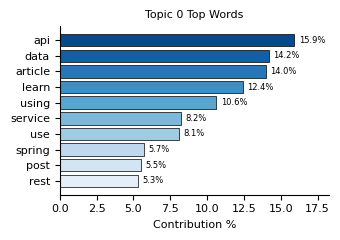

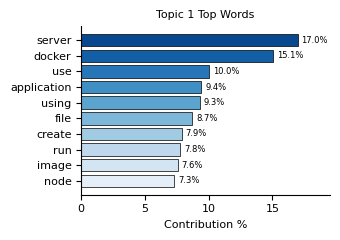

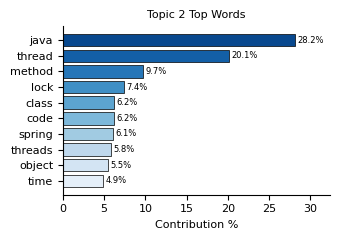

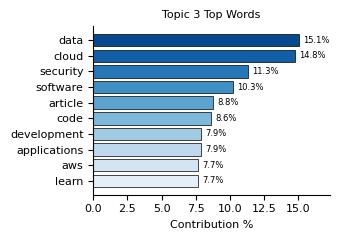

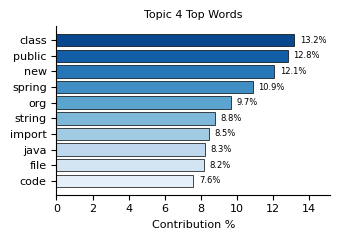

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_ieee_topic_words(lda_model, feature_names, topic_idx, top_n=10,
                         fig_width=3.5, fig_height=2.5):
    """
    Create IEEE-format compatible plot of top words for a given topic
    with right-aligned black percentage labels and thin black borders
    """
    # Get topic weights and words
    topic = lda_model.components_[topic_idx]
    top_indices = topic.argsort()[:-top_n-1:-1]
    top_words = [feature_names[i] for i in top_indices]
    weights = topic[top_indices]

    # Normalize weights to percentages
    weights = (weights / weights.sum()) * 100

    # Create horizontal bar plot with fixed IEEE dimensions
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Create color palette (dark to light blue) and reverse it
    colors = sns.color_palette("Blues", n_colors=len(weights))[::-1]

    # Plot bars with black edge
    bars = ax.barh(range(len(top_words)), weights, color=colors,
                   edgecolor='black', linewidth=0.5)  # Added black edge

    # Calculate the maximum width for consistent spacing
    max_width = max(weights)

    # Customize appearance
    ax.set_yticks(range(len(top_words)))
    ax.set_yticklabels(top_words, fontsize=8)
    ax.set_xlabel('Contribution %', fontsize=8)
    ax.set_title(f'Topic {topic_idx} Top Words', fontsize=8)

    # Set x-axis limits with padding for labels
    ax.set_xlim(0, max_width * 1.15)  # Add 15% padding for labels

    # Add percentage labels to the right of bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                f'{width:.1f}%',
                ha='left', va='center', fontsize=6,
                color='black')  # Black text

    # Invert y-axis to have highest percentages at the top
    ax.invert_yaxis()

    # Remove top and right spines for cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Adjust layout
    ax.tick_params(axis='both', labelsize=8)
    plt.tight_layout()

    return fig, ax

# Use the function
for i in range(LDA.n_components):
    fig, ax = plot_ieee_topic_words(LDA, cv.get_feature_names_out(), i)
    plt.show()

In [ ]:
dtm

<12923x13340 sparse matrix of type '<class 'numpy.int64'>'
	with 334871 stored elements in Compressed Sparse Row format>

In [ ]:
topic_results = LDA.transform(dtm)

In [ ]:
topic_results.shape

(12923, 5)

In [ ]:
topic_results[0].round(2)

array([0.6 , 0.35, 0.02, 0.02, 0.02])

In [ ]:
topic_results[0].argmax()

0

In [ ]:
npr.head()

,Title,URL,Detail,Date,Author,Views
0,Serverless Computing and GraphQL: Modern App D...,https://dzone.com/articles/serverless-computin...,"In this step-by-step guide, learn how to defin...",2024-10-14,balaji thadagam kandavel,"2,860 Views"
1,CI/CD Pipelines in the Cloud: How Cloud Hostin...,https://dzone.com/articles/cicd-pipelines-in-t...,Cloud-hosted CI/CD pipelines enhance software ...,2024-10-14,Anton Lucanus,"2,217 Views"
2,What We Learned About Secrets Security at AppS...,https://dzone.com/articles/secrets-security-at...,"Learn about DEF CON 32: AppSec Village, explor...",2024-10-14,Dwayne McDaniel,"2,051 Views"
3,Mutable vs. Immutable: Infrastructure Models i...,https://dzone.com/articles/infrastructure-mode...,Explore mutable infrastructure and immutable s...,2024-10-14,Josephine Eskaline Joyce,"3,647 Views"
4,An Overview of TCPCopy for Beginners,https://dzone.com/articles/an-overview-of-tcpc...,"In this article, learn more about TCPCopy, an ...",2024-10-11,Bin Wang,"3,245 Views"


In [ ]:
topic_results.argmax(axis=1)

array([0, 3, 0, ..., 4, 1, 4])

In [ ]:
npr['Topic'] = topic_results.argmax(axis=1)

In [ ]:
npr.head(100)

,Title,URL,Detail,Date,Author,Views,Topic
0,Serverless Computing and GraphQL: Modern App D...,https://dzone.com/articles/serverless-computin...,"In this step-by-step guide, learn how to defin...",2024-10-14,balaji thadagam kandavel,"2,860 Views",0
1,CI/CD Pipelines in the Cloud: How Cloud Hostin...,https://dzone.com/articles/cicd-pipelines-in-t...,Cloud-hosted CI/CD pipelines enhance software ...,2024-10-14,Anton Lucanus,"2,217 Views",3
2,What We Learned About Secrets Security at AppS...,https://dzone.com/articles/secrets-security-at...,"Learn about DEF CON 32: AppSec Village, explor...",2024-10-14,Dwayne McDaniel,"2,051 Views",0
3,Mutable vs. Immutable: Infrastructure Models i...,https://dzone.com/articles/infrastructure-mode...,Explore mutable infrastructure and immutable s...,2024-10-14,Josephine Eskaline Joyce,"3,647 Views",3
4,An Overview of TCPCopy for Beginners,https://dzone.com/articles/an-overview-of-tcpc...,"In this article, learn more about TCPCopy, an ...",2024-10-11,Bin Wang,"3,245 Views",3
...,...,...,...,...,...,...,...
95,A Hands-On Guide to OpenTelemetry: Manual Inst...,https://dzone.com/articles/hands-on-guide-to-o...,This article continues the series by explainin...,2024-09-17,Eric D. Schabell,"3,127 Views",0
96,Commonly Occurring Errors in Microsoft Graph I...,https://dzone.com/articles/errors-in-microsoft...,Explore an example to change a column value fo...,2024-09-16,Constantin Kwiatkowski,"2,947 Views",4
97,Observability Agent Architecture,https://dzone.com/articles/observability-agent...,"Explore these practices to build efficient, tr...",2024-09-16,Kranthi Kiran Erusu,"7,030 Views",3
98,Low-Level Optimizations in ClickHouse: Utilizi...,https://dzone.com/articles/low-level-optimizat...,ClickHouse accelerates queries using SIMD and ...,2024-09-16,Taras Baranyuk,"4,059 Views",3


In [ ]:
print(npr['Date'].dtype)

datetime64[ns]


In [ ]:
npr['Date'] = pd.to_datetime(npr['Date'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [ ]:
print(npr['Date'].isna().sum())

0


In [ ]:
npr['Year'] = npr['Date'].dt.year
npr['Month'] = npr['Date'].dt.month
npr['Day'] = npr['Date'].dt.day
npr['Hour'] = npr['Date'].dt.hour
npr['Quarter'] = npr['Date'].dt.to_period('Q')

In [ ]:
# @title
print(npr[['Date', 'Year', 'Month', 'Day', 'Hour', 'Quarter']].head())

        Date  Year  Month  Day  Hour Quarter
0 2024-10-14  2024     10   14     0  2024Q4
1 2024-10-14  2024     10   14     0  2024Q4
2 2024-10-14  2024     10   14     0  2024Q4
3 2024-10-14  2024     10   14     0  2024Q4
4 2024-10-11  2024     10   11     0  2024Q4


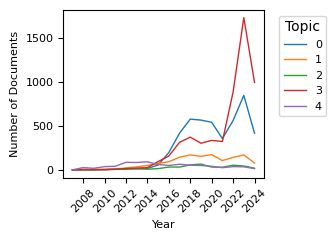

Topic Evolution Table:
Topic    0    1   2     3   4
Year                         
2007     0    0   0     0   1
2008     4    6   0     5  27
2009     2    0   1     7  19
2010     3    5   4     6  38
2011     7   10   7     9  42
2012    14   23   9    16  87
2013    12   35  16    21  85
2014    18   51   9    27  93
2015    56   74  15    95  62
2016   198   94  33   158  51
2017   418  145  33   314  65
2018   578  171  58   373  54
2019   567  156  67   304  51
2020   542  174  33   336  42
2021   357  107  31   324  26
2022   562  143  54   886  38
2023   848  171  45  1732  36
2024   418   79  20   995  15


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Add year column
npr['Year'] = npr['Date'].dt.year

# Filter by date if necessary
npr_filtered = npr[npr['Date'] > '2020-01-01']

# Diachronic analysis after topic modeling
topic_results = LDA.transform(dtm)
npr['Topic'] = topic_results.argmax(axis=1)

# Count topics by year
topic_counts_by_year = npr.groupby(['Year', 'Topic']).size().unstack(fill_value=0)

# Visualize topic evolution over time
fig, ax = plt.subplots(figsize=(3.5, 2.5))  # Ajustado para IEEE

topic_counts_by_year.plot(kind='line', ax=ax, linewidth=1)  # Ajustado para IEEE

# Format x-axis to show only integer years
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)  # Ajusta tamaño de números en ejes
ax.xaxis.set_tick_params(rotation=45)  # Rotar etiquetas de años para evitar superposición

plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of Documents', fontsize=8)
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)  # Ajustado para IEEE
plt.tight_layout()

plt.show()

# Print table data separately
print("Topic Evolution Table:")
print(topic_counts_by_year)

In [ ]:
import yaml

# Load explainability terms from YAML file
with open('/content/drive/MyDrive/Tesis/params.yaml', 'r') as f:
    params = yaml.safe_load(f)

explainability_keywords = params['explainability_terms']
explainability_keywords = [term.lower() for term in explainability_keywords]

print("Explainability Keywords:")
print(explainability_keywords)

# Identify explainability topics (assuming LDA components are already computed)
explainability_topics = []
for index, topic in enumerate(LDA.components_):
    top_words = [cv.get_feature_names_out()[i] for i in topic.argsort()[-50:]]
    if any(term in top_words for term in explainability_keywords):
        explainability_topics.append(index)

print("\nPotential explainability topics:", explainability_topics)

Explainability Keywords:
['explain', 'interpret', 'transparent', 'black-box', 'white-box', 'explainable', 'interpretable', 'explainability', 'interpretability', 'resolvable', 'resolvability', 'explicable', 'explicability', 'answerable', 'answerability', 'feasible', 'feasibility', 'solvable', 'solvability', 'accountability', 'outline', 'traceability', 'describe', 'observability', 'observe', 'monitor', 'trace']

Potential explainability topics: []


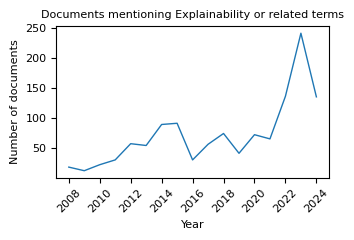

explainability_docs_over_time.csv:
Year,0
2008,19
2009,13
2010,23
2011,31
2012,58
2013,55
2014,90
2015,92
2016,31
2017,57
2018,75
2019,42
2020,73
2021,66
2022,137
2023,242
2024,136




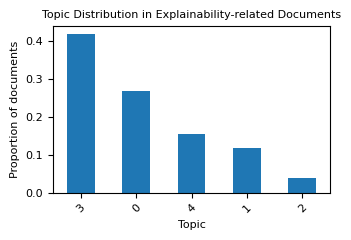

explainability_topic_dist.csv:
Topic,proportion
3,0.41854838709677417
0,0.2693548387096774
4,0.15564516129032258
1,0.11693548387096774
2,0.03951612903225806




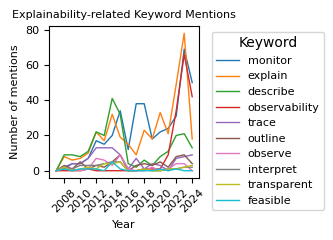

keyword_mentions_over_time.csv:
Year,monitor,explain,describe,observability,trace,outline,observe,interpret,transparent,feasible
2007,0,0,0,0,0,0,0,0,0,0
2008,2,8,9,0,1,3,2,2,2,1
2009,4,6,9,0,4,1,1,1,0,0
2010,4,7,8,0,4,5,0,3,1,1
2011,7,10,11,1,7,1,1,3,2,1
2012,17,22,22,0,13,3,7,3,1,1
2013,15,17,20,0,13,2,6,4,4,0
2014,20,32,41,0,13,5,3,5,4,5
2015,34,19,32,0,9,9,9,5,5,1
2016,12,15,4,0,1,0,1,0,0,0
2017,38,9,2,0,7,3,0,0,0,0
2018,38,23,6,1,1,4,0,1,1,0
2019,18,18,3,1,4,3,2,0,0,0
2020,22,33,8,1,3,5,0,0,0,1
2021,24,21,11,9,0,2,1,1,1,0
2022,31,49,20,34,7,8,4,1,1,1
2023,69,78,21,66,8,9,4,2,2,0
2024,50,18,13,42,9,4,0,2,3,0




In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# Find documents containing explainability-related keywords
explainability_docs = npr[npr['Detail'].str.contains('|'.join(explainability_keywords), case=False)]

# Analyze the evolution of mentions over time
fig, ax = plt.subplots(figsize=(3.5, 2.5))
explainability_docs_over_time = explainability_docs.groupby('Year').size()
explainability_docs_over_time.plot(kind='line', ax=ax, linewidth=1)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Documents mentioning Explainability or related terms', fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of documents', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('explainability_docs_over_time.csv:')
print(explainability_docs_over_time.to_csv())
print()

# Analyze the distribution of topics in these documents
fig, ax = plt.subplots(figsize=(3.5, 2.5))
explainability_topic_dist = explainability_docs['Topic'].value_counts(normalize=True)
explainability_topic_dist.plot(kind='bar', ax=ax)
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Topic Distribution in Explainability-related Documents', fontsize=8)
plt.xlabel('Topic', fontsize=8)
plt.ylabel('Proportion of documents', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('explainability_topic_dist.csv:')
print(explainability_topic_dist.to_csv())
print()

# Analyze the evolution of specific keyword mentions
fig, ax = plt.subplots(figsize=(3.5, 2.5), gridspec_kw={'width_ratios': [1.2]})
keyword_mentions = pd.DataFrame({keyword: npr['Detail'].str.contains(keyword, case=False).astype(int) for keyword in explainability_keywords})
keyword_mentions_over_time = keyword_mentions.groupby(npr['Year']).sum()
top_10_keywords = keyword_mentions.sum().nlargest(10).index
keyword_mentions_over_time[top_10_keywords].plot(ax=ax, linewidth=1)
ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
ax.tick_params(axis='both', labelsize=8)
ax.xaxis.set_tick_params(rotation=45)
plt.title('Explainability-related Keyword Mentions', fontsize=8)
plt.xlabel('Year', fontsize=8)
plt.ylabel('Number of mentions', fontsize=8)
plt.legend(title='Keyword', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

# Print the data as a CSV to the console
print('keyword_mentions_over_time.csv:')
print(keyword_mentions_over_time[top_10_keywords].to_csv())
print()

Processing keywords: 100%|██████████| 27/27 [00:04<00:00,  6.37it/s]


Keywords data saved to file.


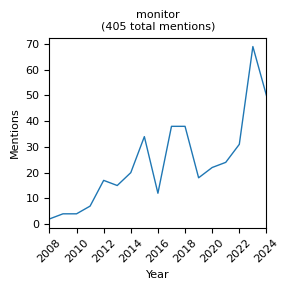

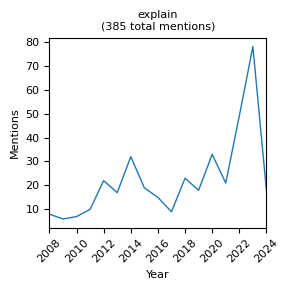

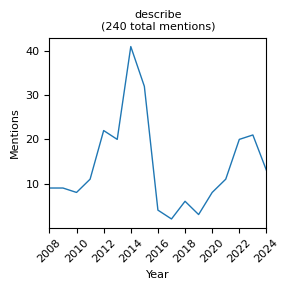

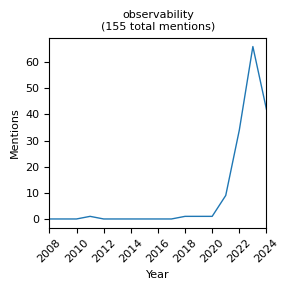

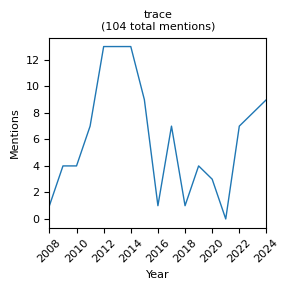

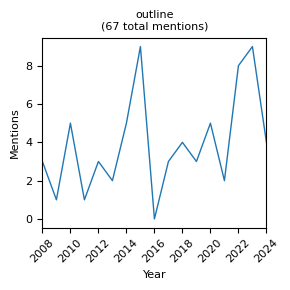

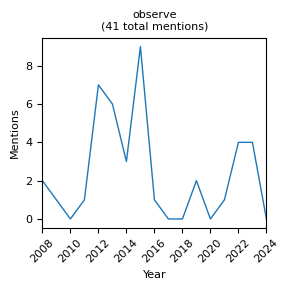

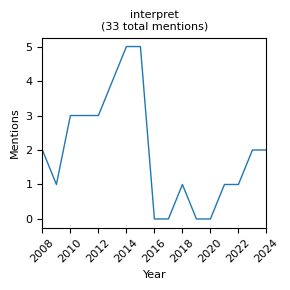

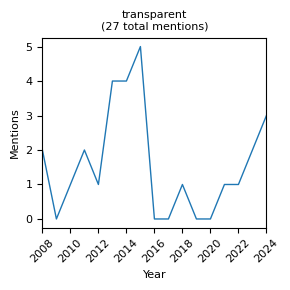

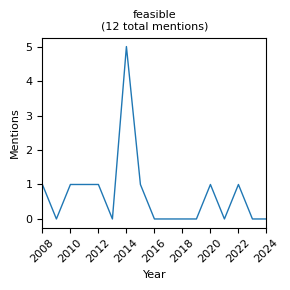

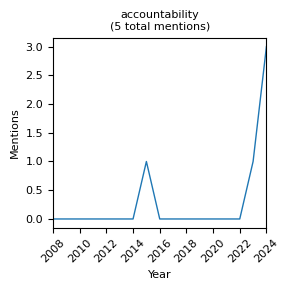

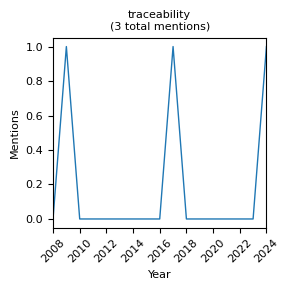

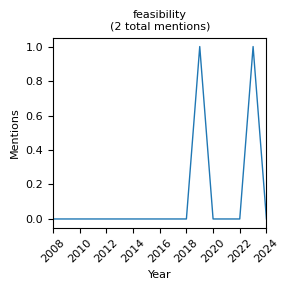

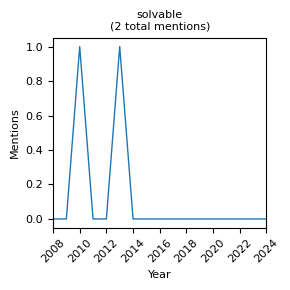

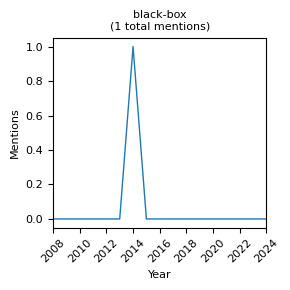

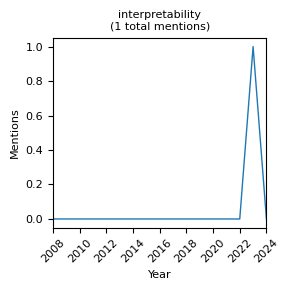

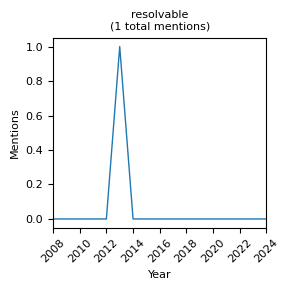

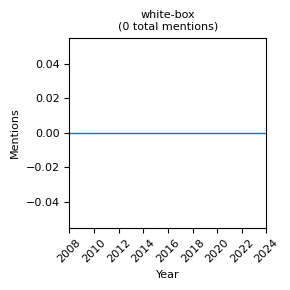

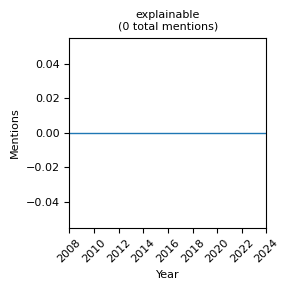

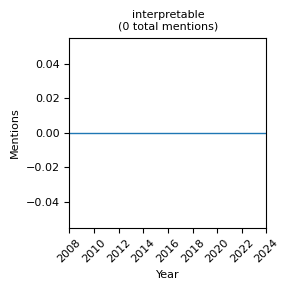

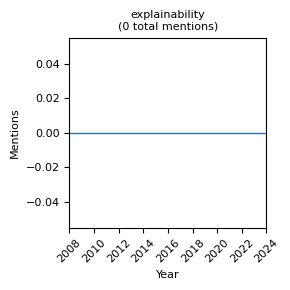

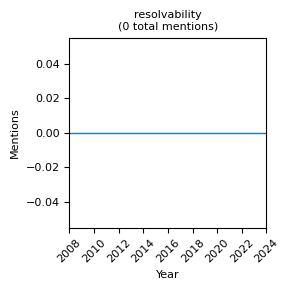

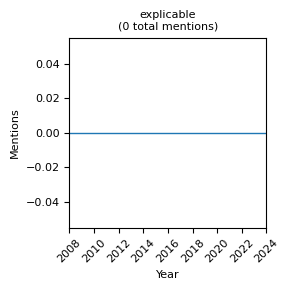

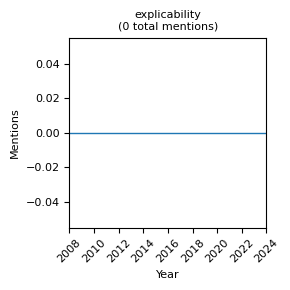

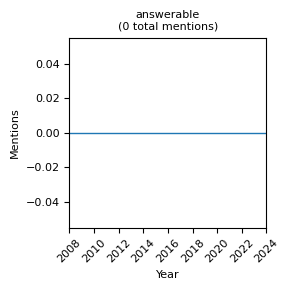

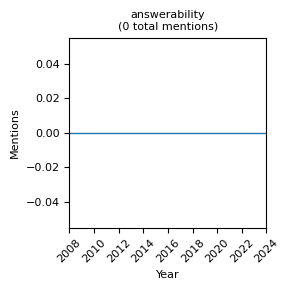

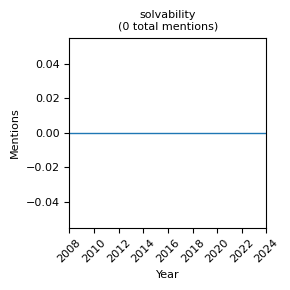


Summary Statistics (ordered by total mentions):

monitor:
Total mentions: 405
Peak mentions: 69 (Year: 2023)

explain:
Total mentions: 385
Peak mentions: 78 (Year: 2023)

describe:
Total mentions: 240
Peak mentions: 41 (Year: 2014)

observability:
Total mentions: 155
Peak mentions: 66 (Year: 2023)

trace:
Total mentions: 104
Peak mentions: 13 (Year: 2012)

outline:
Total mentions: 67
Peak mentions: 9 (Year: 2015)

observe:
Total mentions: 41
Peak mentions: 9 (Year: 2015)

interpret:
Total mentions: 33
Peak mentions: 5 (Year: 2014)

transparent:
Total mentions: 27
Peak mentions: 5 (Year: 2015)

feasible:
Total mentions: 12
Peak mentions: 5 (Year: 2014)

accountability:
Total mentions: 5
Peak mentions: 3 (Year: 2024)

traceability:
Total mentions: 3
Peak mentions: 1 (Year: 2009)

feasibility:
Total mentions: 2
Peak mentions: 1 (Year: 2019)

solvable:
Total mentions: 2
Peak mentions: 1 (Year: 2010)

black-box:
Total mentions: 1
Peak mentions: 1 (Year: 2014)

interpretability:
Total menti

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import math
import os
from tqdm import tqdm

# Results file
keywords_file = f'keywords_data_{data_file}'

# Full path of results file
keywords_path = f'{path}{keywords_file}'

# Check if keywords file already exists
if keywords_file in os.listdir(path):
    # Load existing results
    keywords_data = pd.read_csv(keywords_path)
    print("Keywords data loaded from existing file.")
else:
    # Create a DataFrame to store mentions of each keyword over time
    keywords_data = pd.DataFrame()

    # Ensure we have all years from 2008 to 2024
    full_year_range = pd.DataFrame({'Year': range(2008, 2025)})

    # For each keyword, count mentions per year
    for keyword in tqdm(explainability_keywords, desc="Processing keywords"):
        yearly_counts = npr[npr['Detail'].str.contains(keyword, case=False)].groupby('Year').size()
        # Convert to DataFrame and merge with full year range to ensure all years are present
        keyword_df = pd.DataFrame(yearly_counts).reset_index()
        keyword_df.columns = ['Year', keyword]
        full_data = pd.merge(full_year_range, keyword_df, on='Year', how='left')
        keywords_data[keyword] = full_data[keyword].fillna(0)

    # Add Year column
    keywords_data['Year'] = range(2008, 2025)

    # Save to CSV
    keywords_data.to_csv(keywords_path, index=False)
    print("Keywords data saved to file.")

# Calculate total mentions for each keyword to determine order
keyword_totals = {col: keywords_data[col].sum() for col in keywords_data.columns if col != 'Year'}
sorted_keywords = sorted(keyword_totals.items(), key=lambda x: x[1], reverse=True)

# Create plots in series of 3
plt.ioff()  # Turn off interactive mode
for i in range(0, len(sorted_keywords), 3):
    # Create a batch of up to 3 plots
    batch_keywords = sorted_keywords[i:i+3]

    # Create the plots for this batch
    for j, (keyword, total) in enumerate(batch_keywords):
        fig, ax = plt.subplots(figsize=(3, 3))

        # Plot data without label
        keywords_data.plot(x='Year', y=keyword, ax=ax, linewidth=1, label='')
        ax.set_title(f'{keyword}\n({total:.0f} total mentions)', fontsize=8)
        ax.set_xlabel('Year', fontsize=8)
        ax.set_ylabel('Mentions', fontsize=8)
        ax.tick_params(axis='both', labelsize=8)

        # Set x-axis range and ticks
        ax.set_xlim(2008, 2024)
        ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
        ax.xaxis.set_tick_params(rotation=45)

        # Remove legend
        ax.get_legend().remove()

        plt.tight_layout()

        # Save the plot
        plot_filename = f'{path}keyword_plot_{keyword.replace(" ", "_")}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()

    # Add a newline after each batch of 3
    if i + 3 < len(sorted_keywords):
        print("\n")

plt.ion()  # Turn interactive mode back on

# Print summary statistics for each keyword in order
print("\nSummary Statistics (ordered by total mentions):")
for keyword, total in sorted_keywords:
    max_mentions = keywords_data[keyword].max()
    # Safe way to find the year of maximum mentions
    if max_mentions > 0:  # Only find max year if there are mentions
        max_year = keywords_data.loc[keywords_data[keyword] == max_mentions, 'Year'].iloc[0]
    else:
        max_year = "No mentions"

    print(f"\n{keyword}:")
    print(f"Total mentions: {total:.0f}")
    print(f"Peak mentions: {max_mentions:.0f} (Year: {max_year})")

In [ ]:
for idx, topic in enumerate(LDA.components_):
    topic_words = [cv.get_feature_names_out()[i] for i in topic.argsort()[-100:]]
    explainable_words = [word for word in topic_words if word in explainability_keywords]
    print(f"Tópico {idx + 1} - Palabras relacionadas con explainability: {explainable_words}")

# Análisis de co-ocurrencia
from sklearn.feature_extraction.text import CountVectorizer

# Crear un nuevo vectorizador que incluya los términos de explainability
cv_explain = CountVectorizer(vocabulary=explainability_keywords)
dtm_explain = cv_explain.fit_transform(npr['Detail'])

# Calcular la co-ocurrencia
co_occurrence = (dtm.T @ dtm_explain).toarray()

# Mostrar las 10 palabras que más co-ocurren con cada término de explainability
for idx, keyword in enumerate(explainability_keywords):
    top_co_words = [cv.get_feature_names_out()[i] for i in co_occurrence[:, idx].argsort()[-10:]]
    print(f"Palabras que co-ocurren con '{keyword}': {top_co_words}")

Tópico 1 - Palabras relacionadas con explainability: []
Tópico 2 - Palabras relacionadas con explainability: []
Tópico 3 - Palabras relacionadas con explainability: ['monitor']
Tópico 4 - Palabras relacionadas con explainability: []
Tópico 5 - Palabras relacionadas con explainability: []
Palabras que co-ocurren con 'explain': ['time', 'use', 'data', 'threads', 'lock', 'class', 'object', 'method', 'java', 'thread']
Palabras que co-ocurren con 'interpret': ['service', 'xyz', '10', 'com', 'application', 'version', 'content', 'microservices', 'resource', 'http']
Palabras que co-ocurren con 'transparent': ['service', 'software', 'use', 'cloud', 'process', 'server', 'network', 'storage', 'virtualization', 'data']
Palabras que co-ocurren con 'black-box': ['execution', 'executionexception', 'executions', 'executive', 'executives', 'executor', 'executorchannel', 'executors', 'extracts', 'łukasz']
Palabras que co-ocurren con 'white-box': ['execution', 'executionexception', 'executions', 'executi